# 04. Dimensionality Reduction

[Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction#:~:text=Dimensionality%20reduction%2C%20or%20dimension%20reduction,close%20to%20its%20intrinsic%20dimension.), or dimension reduction, is the transformation of dta from a hig-dimensional space (high number of attributes) into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data, ideally close to its intrinsic dimension. It can be used for noise reduction, data visualization, cluster analysis, or as an intermediate step to facilitate other analyses.


In [3]:
using UMAP
using Makie
using XLSX
using VegaDatasets
using DataFrames
using MultivariateStats
using RDatasets
using StatsBase
using Statistics
using LinearAlgebra
using Plots
using ScikitLearn
using MLBase
using Distances

## Data

In [4]:
dataset = DataFrame(VegaDatasets.dataset("cars"))
names(dataset)

9-element Array{String,1}:
 "Name"
 "Miles_per_Gallon"
 "Cylinders"
 "Displacement"
 "Horsepower"
 "Weight_in_lbs"
 "Acceleration"
 "Year"
 "Origin"

In [20]:
dataset[1:5,:]

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower
,String,Float64?,Int64,Float64,Int64?
1,chevrolet chevelle malibu,18.0,8,307.0,130
2,buick skylark 320,15.0,8,350.0,165
3,plymouth satellite,18.0,8,318.0,150
4,amc rebel sst,16.0,8,304.0,150
5,ford torino,17.0,8,302.0,140


In [5]:
dropmissing!(dataset);
M = Matrix(dataset[:, 2:7]);

In [6]:
car_origin = dataset[:,:Origin]
carmap = MLBase.labelmap(car_origin)
uniqueids = MLBase.labelencode(carmap, car_origin)
carmap

LabelMap (with 3 labels):
[1] USA
[2] Japan
[3] Europe


We first standarize the data:

In [7]:
data = (M .- mean(M,dims = 1)) ./ std(M, dims=1) # z = (x - μ) / σ 

392×6 Array{Float64,2}:
 -0.697747   1.48205    1.07591    0.663285   0.619748   -1.28362
 -1.08212    1.48205    1.48683    1.57258    0.842258   -1.46485
 -0.697747   1.48205    1.18103    1.18288    0.539692   -1.64609
 -0.953992   1.48205    1.04725    1.18288    0.53616    -1.28362
 -0.82587    1.48205    1.02813    0.923085   0.554997   -1.82732
 -1.08212    1.48205    2.24177    2.42992    1.60515    -2.00855
 -1.21024    1.48205    2.48068    3.00148    1.62045    -2.37102
 -1.21024    1.48205    2.34689    2.87158    1.57101    -2.55226
 -1.21024    1.48205    2.49023    3.13138    1.70404    -2.00855
 -1.08212    1.48205    1.86908    2.22208    1.02709    -2.55226
 -1.08212    1.48205    1.80219    1.70248    0.689209   -2.00855
 -1.21024    1.48205    1.39127    1.44268    0.743365   -2.73349
 -1.08212    1.48205    1.96464    1.18288    0.922314   -2.18979
  ⋮                                                       ⋮
  0.199113   0.309571  -0.128168   0.143685  -0.0383613   

## PCA

PCA expects each column to be an instance, so we must transpose he matrix.

In [43]:
X = data'

6×392 Adjoint{Float64,Array{Float64,2}}:
 -0.697747  -1.08212   -0.697747  …   1.09597    0.583482   0.967851
  1.48205    1.48205    1.48205      -0.862911  -0.862911  -0.862911
  1.07591    1.48683    1.18103      -0.567753  -0.711097  -0.720653
  0.663285   1.57258    1.18288      -0.531795  -0.661694  -0.583754
  0.619748   0.842258   0.539692     -0.803605  -0.415097  -0.303253
 -1.28362   -1.46485   -1.64609   …  -1.4286     1.10867    1.39865

When creating the PCA model we must specify the output dimensions with the argument *maxoutdim*.

In [41]:
pca_model = MultivariateStats.fit(PCA, X, maxoutdim=2)

PCA(indim = 6, outdim = 2, principalratio = 0.9194828785333573)

To transform the data we can use the *transform* function:

In [45]:
Yte = MultivariateStats.transform(pca_model, X)

2×392 Array{Float64,2}:
 -2.323     -3.20196  -2.66658   -2.60214   …   1.22011  1.70921   1.86951
 -0.571352  -0.68187  -0.992744  -0.621975     -1.87471  0.632857  0.815607

We can also go back to the original dimensions, although the values will be an approximation of the original ones.

In [46]:
Xr = MultivariateStats.reconstruct(pca_model, Yte)

6×392 Array{Float64,2}:
 -0.786928  -1.11055  -0.820834  …   0.945785   0.526984   0.546196
  0.91558    1.27768   1.00103      -0.803445  -0.64215   -0.684075
  0.968334   1.34619   1.075        -0.744559  -0.689425  -0.740696
  1.1034     1.50334   1.32257      -0.218179  -0.847159  -0.947116
  0.835669   1.18209   0.862883     -1.06112   -0.554079  -0.570742
 -1.18816   -1.54341  -1.66462   …  -1.31728    1.06388    1.27381

In [48]:
norm(Xr-X) # The norm(Xr-X) is not zero because the reconstruction doesn't provide the exact original values

13.743841055569009

Since we have reduced the dimensions from 6 to 2, we can now plot the data easily.

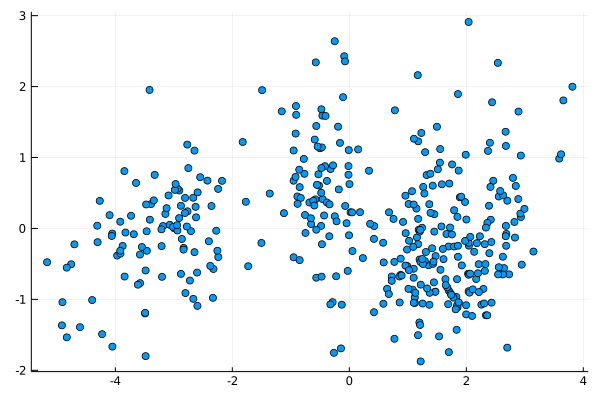

In [50]:
Plots.scatter(Yte[1,:], Yte[2,:], legend=false)

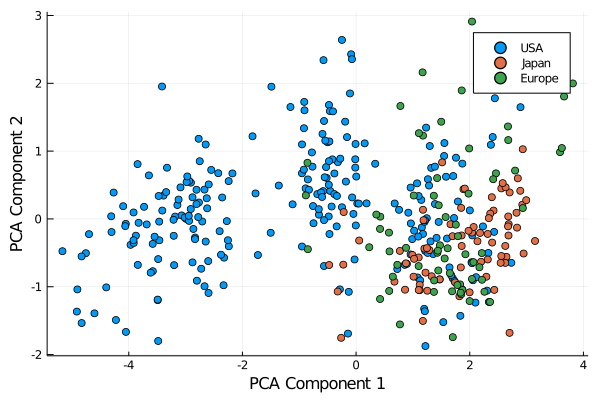

In [57]:
Plots.scatter(Yte[1,car_origin.=="USA"], Yte[2,car_origin.=="USA"], color=1, label="USA")
Plots.scatter!(Yte[1,car_origin.=="Japan"], Yte[2,car_origin.=="Japan"], color=2, label="Japan")
Plots.scatter!(Yte[1,car_origin.=="Europe"], Yte[2,car_origin.=="Europe"], color=3, label="Europe")
Plots.xlabel!("PCA Component 1")
Plots.ylabel!("PCA Component 2")

We can try now to reduce the data to only 3 dimensions and visualize it in a 3D plot

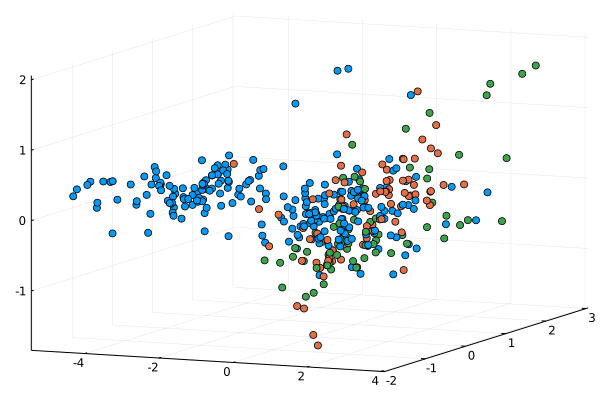

In [61]:
pca_model = MultivariateStats.fit(PCA, X, maxoutdim=3)
Yte = MultivariateStats.transform(pca_model, X)
Plots.scatter3d(Yte[1,:],Yte[2,:],Yte[3,:],color=uniqueids,legend=false)

We can use the *Makie* package to generate an interactive 3D Scatter plot

In [64]:
scene = Makie.scatter(Yte[1,:],Yte[2,:],Yte[3,:],color=uniqueids);

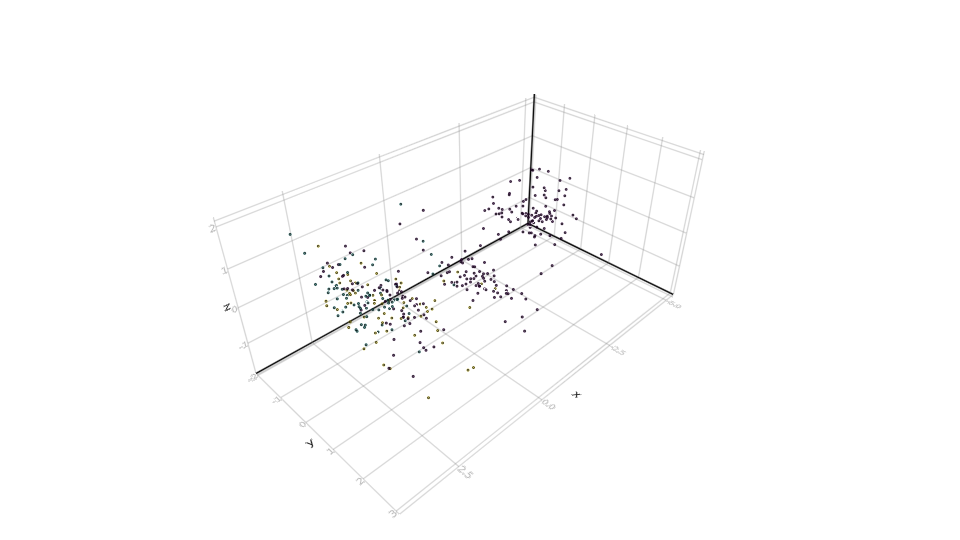

In [71]:
Makie.display(scene)

## t-SNE
T-distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique useful for visualization of high-dimensional datasets.

There are [different possibilities](https://github.com/nassarhuda/JuliaTutorials/blob/master/TSNE/TSNE.ipynb.) when using the t-SNE in Julia, including the *tSne.jl* package. This time we are going to use the implementation of this algorithm contained in the *ScikitLearn.jl* package.

In order to use the *ScikitLearn.jl* package, it is necessary to have the corresponding Python module.

In [74]:
@sk_import manifold : TSNE

PyObject <class 'sklearn.manifold._t_sne.TSNE'>

In [75]:
tfn = TSNE(n_components=2)
Y2 = tfn.fit_transform(data)

392×2 Array{Float32,2}:
   6.40415   27.1609
   5.08803   31.7875
   5.08876   28.4523
   5.95462   28.2233
   4.73591   28.146
   4.09533   36.6029
   3.35174   37.1648
   3.19715   36.763
   3.54417   37.6836
   3.20994   34.6243
   3.77169   32.6402
   2.94547   32.1168
   3.50273   32.0689
   ⋮        
  23.1409    -1.55327
  -2.78841  -19.6468
  -8.6479    -6.32351
  18.5877    -0.162276
 -20.4819   -13.458
 -19.257    -13.8865
  -3.76108  -12.6269
  -7.48596   -8.6386
  -4.53204  -23.2607
 -19.0859   -12.2996
  -4.14081  -15.5053
  -4.14815  -16.9731

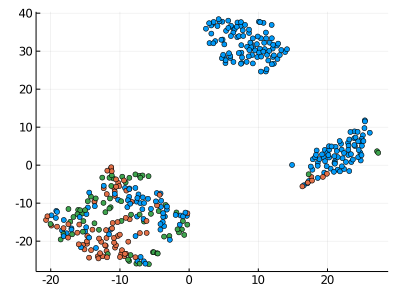

In [76]:
Plots.scatter(Y2[:,1],Y2[:,2],color=uniqueids,legend=false,size=(400,300),markersize=3)

## UMAP

Uniform manifold approximation and projection (UMAP) is a nonlinear dimensionality reduction technique. Visually, it is similar to t-SNE, but it assumes that the data is uniformly distributed on a locally connected Riemannian manifold and that the Riemannian metric is locally constant or approximately locally constant.

We will use the *UMAP.jl* package for it.

In [ ]:
L = Statistics.cor(data, data, dims=2)
embedding = UMAP.umap(L,2) # Execution error

In [ ]:
Plots.scatter(embedding[1,:],embedding[2,:],color=uniqueids)